# Detecting Bike Helmets Using YOLOv11: A Step Towards Safer Roads

## Introduction

In this project, we focus on developing a robust object detection system to identify whether individuals riding bikes are wearing helmets. Ensuring helmet compliance is crucial for enhancing road safety and reducing the risk of severe head injuries in accidents. Using the YOLOv11 (You Only Look Once) algorithm, we leverage its state-of-the-art capabilities in real-time object detection to achieve accurate classification and localization of bike riders with or without helmets. The dataset comprises labeled images with annotations in XML format, which we preprocess and convert into YOLO-compatible format for training.

Through this notebook, we showcase:
- The dataset preparation process, including splitting, annotation conversion, and augmentation.
- Training the YOLOv11 model to achieve high accuracy in detecting helmet use.
- Using the trained model for inference on images and videos to demonstrate its real-world applicability.

By the end of this notebook, you'll see how cutting-edge deep learning models can contribute to impactful applications like road sa law enforcement.


In [16]:
!pip install roboflow -q
!pip install ultralytics -q

In [17]:
from kaggle_secrets import UserSecretsClient
from roboflow import Roboflow

# Get the secret API key
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("roboflow")  # This fetches your Roboflow API key

# Initialize the Roboflow client with the API key
rf = Roboflow(api_key=secret_value_0)


loading Roboflow workspace...
loading Roboflow project...


### **Show data sample**

In [18]:
import cv2
import random
import glob as glob
import matplotlib.pyplot as plt
import numpy as np
import os
import xml.etree.ElementTree as ET
np.random.seed(42)

In [42]:
import os
import random
import shutil
import xml.etree.ElementTree as ET

def convert_to_yolo_format(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0 - 1
    y = (box[2] + box[3]) / 2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

def convert_annotation(xml_file, image_dir, output_dir):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    # Get the base filename for output
    image_filename = os.path.splitext(os.path.basename(xml_file))[0] + '.jpg'
    output_path = os.path.join(output_dir, os.path.splitext(os.path.basename(xml_file))[0] + '.txt')

    with open(output_path, 'w') as out_file:
        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls in ["With Helmet", "Without Helmet"] and int(difficult) == 0:
                cls_id = 0 if cls == "With Helmet" else 1
                xmlbox = obj.find('bndbox')
                b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text),
                     float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
                bb = convert_to_yolo_format((w, h), b)
                out_file.write(f"{cls_id} " + " ".join([str(a) for a in bb]) + '\n')

def organize_dataset(xml_dir, image_dir, output_dir, split_ratio=0.8):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Create train and val directories
    train_image_dir = os.path.join(output_dir, 'images/train')
    val_image_dir = os.path.join(output_dir, 'images/val')
    train_label_dir = os.path.join(output_dir, 'labels/train')
    val_label_dir = os.path.join(output_dir, 'labels/val')

    for dir_path in [train_image_dir, val_image_dir, train_label_dir, val_label_dir]:
        os.makedirs(dir_path, exist_ok=True)

    # Gather all XML files
    xml_files = [f for f in os.listdir(xml_dir) if f.endswith('.xml')]
    random.shuffle(xml_files)

    train_count = int(len(xml_files) * split_ratio)

    # Split and process data
    for idx, xml_file in enumerate(xml_files):
        base_filename = os.path.splitext(xml_file)[0]
        image_file = os.path.join(image_dir, base_filename + '.png')
        target_dir = train_image_dir if idx < train_count else val_image_dir
        label_dir = train_label_dir if idx < train_count else val_label_dir

        # Copy image
        shutil.copy(image_file, target_dir)

        # Convert annotation and place in labels directory
        convert_annotation(os.path.join(xml_dir, xml_file), image_dir, label_dir)


In [43]:

# Define paths
xml_dir = '/kaggle/input/bike-helmets-detection/annotations'
image_dir = '/kaggle/input/bike-helmets-detection/images'
output_dir = '/kaggle/working/dataset'

# Organize dataset into YOLO format
organize_dataset(xml_dir, image_dir, output_dir, split_ratio=0.8)


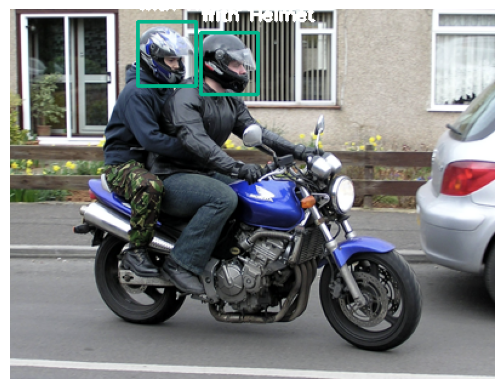

In [44]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def load_yolo_annotations(txt_file, image_size):
    """
    Load YOLO formatted annotations from a .txt file.
    Args:
    - txt_file: Path to the annotation file.
    - image_size: Tuple (width, height) of the image.
    
    Returns:
    - List of bounding boxes and their respective class IDs.
    """
    with open(txt_file, 'r') as f:
        lines = f.readlines()
    
    bboxes = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        
        # Denormalize the bounding box coordinates to pixel values
        img_w, img_h = image_size
        x_center *= img_w
        y_center *= img_h
        width *= img_w
        height *= img_h
        
        xmin = int(x_center - width / 2)
        ymin = int(y_center - height / 2)
        xmax = int(x_center + width / 2)
        ymax = int(y_center + height / 2)
        
        bboxes.append((class_id, xmin, ymin, xmax, ymax))
    
    return bboxes

def plot_image_with_annotations(image_path, txt_file):
    """
    Plot the image with its YOLO annotations overlaid.
    Args:
    - image_path: Path to the image file.
    - txt_file: Path to the corresponding annotation file.
    """
    image = cv2.imread(image_path)
    image_h, image_w, _ = image.shape
    
    # Load the YOLO annotations
    bboxes = load_yolo_annotations(txt_file, (image_w, image_h))
    
    # Define class names (ensure they match the classes in your annotations)
    class_names = ['With Helmet', 'Without Helmet']
    colors = np.random.uniform(0, 255, size=(len(class_names), 2))
    
    # Plot the bounding boxes
    for class_id, xmin, ymin, xmax, ymax in bboxes:
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color=colors[class_id], thickness=2)
        label = class_names[class_id]
        
        # Add label text
        font_scale = 0.5
        font_thickness = 2
        cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), font_thickness)
    
    # Convert image to RGB (OpenCV uses BGR by default)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Example of how to plot a sample image with its annotation
# Ensure your `xml_dir` and `output_dir` are correct paths
image_path = '/kaggle/working/dataset/images/train/BikesHelmets1.png'
txt_file = '/kaggle/working/dataset/labels/train/BikesHelmets1.txt'
plot_image_with_annotations(image_path, txt_file)


## create yaml data for training

In [45]:
import os
import yaml

def create_yaml_file(image_dir, label_dir, output_yaml_path, class_names):
    """
    Create a YAML configuration file for YOLOv11 training.

    Args:
    - image_dir: Directory containing train and validation image subdirectories.
    - label_dir: Directory containing train and validation label subdirectories.
    - output_yaml_path: Path to save the data.yaml file.
    - class_names: List of class names.
    """
    # Validate that train and val directories exist
    train_images = os.path.join(image_dir, 'train')
    val_images = os.path.join(image_dir, 'val')
    
    if not os.path.exists(train_images):
        raise FileNotFoundError(f"Train image directory not found: {train_images}")
    if not os.path.exists(val_images):
        raise FileNotFoundError(f"Validation image directory not found: {val_images}")

    # Create the data.yaml structure
    data_yaml = {
        'train': train_images,
        'val': val_images,
        'nc': len(class_names),
        'names': class_names
    }

    # Write the YAML configuration file
    with open(output_yaml_path, 'w') as yaml_file:
        yaml.dump(data_yaml, yaml_file, default_flow_style=False)
    
    print(f"data.yaml file created successfully at: {output_yaml_path}")

# Define class names and directories
class_names = ['With Helmet', 'Without Helmet']

# Update these paths based on your dataset structure
image_dir = '/kaggle/working/dataset/images'  # This directory should contain 'train' and 'val' subdirectories
label_dir = '/kaggle/working/dataset/labels'  # Label directory (not used in YAML for YOLOv11)
output_yaml_path = '/kaggle/working/data.yaml'  # Path to save the YAML file

# Create the YAML file
create_yaml_file(image_dir, label_dir, output_yaml_path, class_names)


data.yaml file created successfully at: /kaggle/working/data.yaml


In [46]:
import os

# Verify the paths
train_images = os.listdir('/kaggle/working/dataset/images/train')
val_images = os.listdir('/kaggle/working/dataset/images/val')

print("Training images:", train_images[:5])  # Print first 5 training images
print("Validation images:", val_images[:5])  # Print first 5 validation images


Training images: ['BikesHelmets310.png', 'BikesHelmets210.png', 'BikesHelmets18.png', 'BikesHelmets113.png', 'BikesHelmets314.png']
Validation images: ['BikesHelmets332.png', 'BikesHelmets505.png', 'BikesHelmets179.png', 'BikesHelmets680.png', 'BikesHelmets696.png']


### **training YOLOV11**

In [27]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO11n model
model = YOLO("yolo11n.pt")

In [47]:
# Use the model
results = model.train(data="/kaggle/working/data.yaml", epochs=100)  # train the model

Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

train: Scanning /kaggle/working/dataset/labels/train... 611 images, 1 backgrounds, 12 corrupt: 100%|██████████| 611/611 [00:01<00:00, 451.18it/s]

train: WARNING ⚠️ /kaggle/working/dataset/images/train/BikesHelmets103.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     408.72      81.498      71.037      83.004]
train: WARNING ⚠️ /kaggle/working/dataset/images/train/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      263.5      42.997          85          74]
train: WARNING ⚠️ /kaggle/working/dataset/images/train/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      194.5      55.998         103         100]
train: WARNING ⚠️ /kaggle/working/dataset/images/train/BikesHelmets343.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     682.27       150.5      118.22         107]
train: WARNING ⚠️ /kaggle/working/dataset/images/train/BikesHelmets441.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      310.5      41.497          61          63]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.22 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/dataset/labels/val... 153 images, 2 backgrounds, 3 corrupt: 100%|██████████| 153/153 [00:00<00:00, 454.90it/s]

val: WARNING ⚠️ /kaggle/working/dataset/images/val/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     547.68      84.496      132.16         151]
val: WARNING ⚠️ /kaggle/working/dataset/images/val/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        157      56.498          86          97]
val: WARNING ⚠️ /kaggle/working/dataset/images/val/BikesHelmets616.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        750      297.49          68          91]
val: New cache created: /kaggle/working/dataset/labels/val.cache


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.66G      1.581      2.982      1.307         27        640: 100%|██████████| 38/38 [00:10<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

                   all        150        277    0.00587      0.938      0.257      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.68G        1.4      1.895      1.198         24        640: 100%|██████████| 38/38 [00:08<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]


                   all        150        277      0.813      0.133      0.441      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.66G      1.428      1.748      1.205         24        640: 100%|██████████| 38/38 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]


                   all        150        277      0.615      0.582      0.582      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.66G      1.441      1.619      1.226         20        640: 100%|██████████| 38/38 [00:08<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


                   all        150        277      0.669       0.66      0.698      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.62G      1.394      1.453      1.196         29        640: 100%|██████████| 38/38 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

                   all        150        277      0.575      0.685      0.678      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.66G      1.406      1.434      1.211         26        640: 100%|██████████| 38/38 [00:07<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]

                   all        150        277      0.655      0.726      0.675      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.61G      1.374      1.347      1.192         19        640: 100%|██████████| 38/38 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.81it/s]


                   all        150        277      0.622      0.725      0.632      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.64G      1.357      1.263       1.19         21        640: 100%|██████████| 38/38 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

                   all        150        277      0.732      0.687       0.72      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.61G      1.379      1.212      1.184         24        640: 100%|██████████| 38/38 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]

                   all        150        277      0.642      0.731       0.74      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.66G      1.353      1.135       1.16         25        640: 100%|██████████| 38/38 [00:07<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.36it/s]

                   all        150        277      0.684      0.747      0.736       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.61G      1.316      1.111      1.162         25        640: 100%|██████████| 38/38 [00:08<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]

                   all        150        277      0.631      0.693      0.674      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.64G      1.333      1.113       1.15         39        640: 100%|██████████| 38/38 [00:07<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.62it/s]

                   all        150        277      0.663      0.701      0.705       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.62G      1.332      1.064      1.177         17        640: 100%|██████████| 38/38 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.29it/s]

                   all        150        277      0.683      0.759      0.723      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.65G      1.317      1.051      1.169         16        640: 100%|██████████| 38/38 [00:08<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]

                   all        150        277      0.716      0.737      0.715      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.64G      1.305     0.9995      1.146         20        640: 100%|██████████| 38/38 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.36it/s]

                   all        150        277      0.714      0.784       0.76       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.64G      1.295     0.9751      1.151         25        640: 100%|██████████| 38/38 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

                   all        150        277      0.748      0.808      0.796      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.64G      1.249     0.9375      1.129         25        640: 100%|██████████| 38/38 [00:08<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


                   all        150        277      0.705      0.784      0.773      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.67G      1.277     0.9219      1.139         18        640: 100%|██████████| 38/38 [00:07<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]

                   all        150        277       0.64      0.774      0.748      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.63G      1.286     0.9358      1.121         19        640: 100%|██████████| 38/38 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]

                   all        150        277       0.69       0.74      0.754      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.66G      1.292     0.9293      1.159         27        640: 100%|██████████| 38/38 [00:08<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]

                   all        150        277       0.68      0.803      0.785      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.61G       1.24     0.8648      1.117         19        640: 100%|██████████| 38/38 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.56it/s]

                   all        150        277      0.723      0.744      0.786      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.66G      1.248     0.8574      1.119         23        640: 100%|██████████| 38/38 [00:07<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]


                   all        150        277      0.732      0.757      0.774      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.61G      1.239     0.8784      1.131         22        640: 100%|██████████| 38/38 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.39it/s]

                   all        150        277      0.762      0.733      0.801      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.65G      1.237     0.8581      1.112         25        640: 100%|██████████| 38/38 [00:08<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]

                   all        150        277      0.718      0.763      0.779      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.61G      1.254     0.8822      1.114         13        640: 100%|██████████| 38/38 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.34it/s]

                   all        150        277      0.724      0.792      0.803        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.65G      1.243     0.8393      1.111         21        640: 100%|██████████| 38/38 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]

                   all        150        277       0.72      0.766      0.801      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.61G      1.207     0.8231      1.107         11        640: 100%|██████████| 38/38 [00:08<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.55it/s]

                   all        150        277      0.733      0.767      0.785       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.68G       1.22     0.8382      1.124         27        640: 100%|██████████| 38/38 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]

                   all        150        277      0.725      0.826      0.802      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.61G      1.218     0.8312      1.117         18        640: 100%|██████████| 38/38 [00:08<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]

                   all        150        277      0.785      0.749      0.814      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.68G      1.226     0.8076      1.122         22        640: 100%|██████████| 38/38 [00:08<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]

                   all        150        277      0.652      0.814      0.777      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.63G       1.21     0.7965      1.098         26        640: 100%|██████████| 38/38 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]

                   all        150        277      0.778      0.768       0.79      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.66G      1.175     0.7853      1.104         13        640: 100%|██████████| 38/38 [00:08<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]

                   all        150        277      0.717      0.755      0.787       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.61G      1.179     0.8123      1.088         22        640: 100%|██████████| 38/38 [00:08<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.11it/s]

                   all        150        277      0.738      0.768      0.792      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.66G      1.182     0.7708      1.097         22        640: 100%|██████████| 38/38 [00:07<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.29it/s]

                   all        150        277      0.674      0.827      0.792      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.61G      1.178     0.7975      1.101         30        640: 100%|██████████| 38/38 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.32it/s]

                   all        150        277      0.783      0.733      0.797      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.67G      1.154     0.7664      1.069         25        640: 100%|██████████| 38/38 [00:08<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]

                   all        150        277      0.724      0.801      0.803      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.63G      1.169     0.7497      1.098         18        640: 100%|██████████| 38/38 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.37it/s]

                   all        150        277      0.773      0.741      0.788      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.67G      1.191     0.7545        1.1         17        640: 100%|██████████| 38/38 [00:08<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]

                   all        150        277       0.74      0.792      0.796      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.61G      1.174     0.7521      1.085         23        640: 100%|██████████| 38/38 [00:08<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.37it/s]

                   all        150        277      0.768      0.763      0.807      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.66G      1.151     0.7321       1.08         12        640: 100%|██████████| 38/38 [00:08<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.50it/s]

                   all        150        277       0.71      0.819      0.791      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.61G      1.149     0.7193      1.076         22        640: 100%|██████████| 38/38 [00:08<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.51it/s]

                   all        150        277      0.736      0.825      0.808      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.67G      1.159     0.7468      1.075         29        640: 100%|██████████| 38/38 [00:07<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]

                   all        150        277      0.773       0.77      0.812      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.62G      1.157     0.7282      1.084         15        640: 100%|██████████| 38/38 [00:08<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.46it/s]

                   all        150        277      0.762      0.746        0.8      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.66G       1.15     0.7481      1.084         16        640: 100%|██████████| 38/38 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]

                   all        150        277      0.749      0.779      0.816      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.59G       1.17     0.7736      1.101         18        640: 100%|██████████| 38/38 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.46it/s]

                   all        150        277       0.75      0.812      0.822      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.66G      1.133     0.7107      1.072         25        640: 100%|██████████| 38/38 [00:08<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.50it/s]

                   all        150        277      0.739      0.806      0.796      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.59G      1.108     0.7034      1.056         29        640: 100%|██████████| 38/38 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]

                   all        150        277      0.734      0.836      0.788      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.65G      1.109     0.7105      1.046         30        640: 100%|██████████| 38/38 [00:07<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.69it/s]

                   all        150        277      0.739      0.814      0.825       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.62G      1.111      0.693      1.057         18        640: 100%|██████████| 38/38 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.28it/s]

                   all        150        277      0.765      0.819      0.803      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.66G        1.1     0.6862      1.064         26        640: 100%|██████████| 38/38 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.47it/s]

                   all        150        277      0.728      0.851      0.819      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.62G      1.114     0.6736      1.063         18        640: 100%|██████████| 38/38 [00:07<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.34it/s]

                   all        150        277      0.756      0.836      0.831      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.68G      1.083     0.6667       1.05         25        640: 100%|██████████| 38/38 [00:07<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.61it/s]

                   all        150        277      0.754        0.8      0.813      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.59G      1.078     0.6546      1.035         34        640: 100%|██████████| 38/38 [00:08<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]

                   all        150        277      0.769       0.79      0.825      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.68G      1.076     0.6644      1.043         23        640: 100%|██████████| 38/38 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.34it/s]

                   all        150        277      0.747      0.813      0.835      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.63G       1.09     0.6485      1.047         25        640: 100%|██████████| 38/38 [00:07<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]

                   all        150        277      0.772      0.788      0.814      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.66G       1.08     0.6491      1.039         29        640: 100%|██████████| 38/38 [00:08<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.29it/s]

                   all        150        277      0.784      0.813       0.82      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.63G      1.057     0.6321      1.033         27        640: 100%|██████████| 38/38 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.32it/s]

                   all        150        277      0.725      0.832      0.805      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.68G      1.057     0.6535      1.023         31        640: 100%|██████████| 38/38 [00:07<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.49it/s]

                   all        150        277      0.761      0.819      0.817      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.63G       1.04     0.6349      1.027         28        640: 100%|██████████| 38/38 [00:08<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.38it/s]

                   all        150        277      0.783      0.797      0.816      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.65G      1.058     0.6421      1.025         17        640: 100%|██████████| 38/38 [00:07<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.31it/s]

                   all        150        277      0.697      0.825      0.816      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.63G      1.039     0.6261      1.021         20        640: 100%|██████████| 38/38 [00:08<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.42it/s]

                   all        150        277      0.798      0.812      0.811       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.66G      1.036     0.6373      1.026         20        640: 100%|██████████| 38/38 [00:07<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.09it/s]

                   all        150        277      0.728      0.835      0.807      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.59G      1.033     0.6104      1.029         22        640: 100%|██████████| 38/38 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.43it/s]

                   all        150        277      0.741      0.825      0.817      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.66G      1.036     0.6132      1.021         19        640: 100%|██████████| 38/38 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.29it/s]

                   all        150        277      0.783      0.782      0.811      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.61G      1.031      0.616      1.017         28        640: 100%|██████████| 38/38 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]

                   all        150        277      0.785        0.8      0.833      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.66G      1.037     0.5962      1.021         22        640: 100%|██████████| 38/38 [00:08<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]

                   all        150        277      0.774      0.767      0.812      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.61G      1.036     0.6123      1.017         23        640: 100%|██████████| 38/38 [00:07<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.38it/s]

                   all        150        277      0.773      0.797      0.824       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.66G      1.021     0.6079      1.009         38        640: 100%|██████████| 38/38 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]

                   all        150        277       0.78      0.779      0.817      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.61G      1.023     0.5885      1.007         20        640: 100%|██████████| 38/38 [00:08<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]

                   all        150        277      0.826      0.767      0.824      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.64G     0.9899     0.5669      1.001         41        640: 100%|██████████| 38/38 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.29it/s]

                   all        150        277      0.769      0.797      0.803      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.59G      1.004     0.5912      1.015         22        640: 100%|██████████| 38/38 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.52it/s]

                   all        150        277      0.776      0.793      0.807      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.68G     0.9948     0.5875     0.9983         23        640: 100%|██████████| 38/38 [00:08<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.61it/s]

                   all        150        277      0.756      0.792      0.796       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.61G     0.9853     0.5527      1.003         27        640: 100%|██████████| 38/38 [00:07<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]

                   all        150        277      0.751      0.795      0.796       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.68G     0.9878     0.5745     0.9932         28        640: 100%|██████████| 38/38 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]


                   all        150        277      0.765       0.79      0.809      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.61G     0.9495     0.5473      1.002         22        640: 100%|██████████| 38/38 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.26it/s]

                   all        150        277      0.747      0.806      0.816      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.68G     0.9791     0.5439     0.9965         20        640: 100%|██████████| 38/38 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]

                   all        150        277       0.75      0.816      0.806      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.64G     0.9656     0.5673     0.9959         15        640: 100%|██████████| 38/38 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]

                   all        150        277      0.787      0.771      0.805      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.65G     0.9529     0.5538     0.9841         16        640: 100%|██████████| 38/38 [00:08<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]

                   all        150        277      0.799      0.752      0.804      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.61G     0.9532     0.5372     0.9867         19        640: 100%|██████████| 38/38 [00:08<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.34it/s]

                   all        150        277      0.787      0.789      0.801      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.65G     0.9675     0.5624      1.003         24        640: 100%|██████████| 38/38 [00:07<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.49it/s]

                   all        150        277      0.733      0.837       0.81       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.62G     0.9616     0.5543     0.9938         21        640: 100%|██████████| 38/38 [00:07<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.61it/s]

                   all        150        277      0.803      0.773      0.817      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.65G     0.9248     0.5289      0.982         26        640: 100%|██████████| 38/38 [00:08<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

                   all        150        277      0.789      0.803      0.815       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.59G     0.9362     0.5327     0.9837         22        640: 100%|██████████| 38/38 [00:07<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]

                   all        150        277      0.809      0.771       0.81      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.67G     0.9253     0.5209      0.978         24        640: 100%|██████████| 38/38 [00:07<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]

                   all        150        277      0.796      0.779      0.821      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.63G     0.9313     0.5512     0.9837         18        640: 100%|██████████| 38/38 [00:08<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]

                   all        150        277      0.807      0.752      0.806      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.67G     0.9273     0.5303     0.9782         27        640: 100%|██████████| 38/38 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]

                   all        150        277      0.805      0.765      0.807      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.62G     0.9128     0.5246     0.9763         20        640: 100%|██████████| 38/38 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]

                   all        150        277       0.76      0.831      0.813      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.66G     0.9205     0.5315     0.9896         27        640: 100%|██████████| 38/38 [00:08<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.49it/s]

                   all        150        277      0.812      0.768       0.82      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.63G     0.8942     0.5085     0.9663         28        640: 100%|██████████| 38/38 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]

                   all        150        277      0.756       0.81      0.815      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.66G     0.9106     0.5229     0.9796         23        640: 100%|██████████| 38/38 [00:08<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]

                   all        150        277      0.784      0.799      0.818      0.519


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       2.6G     0.8808     0.4752     0.9758         14        640: 100%|██████████| 38/38 [00:09<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]

                   all        150        277      0.782      0.813      0.808      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.64G     0.8673       0.46      0.948         19        640: 100%|██████████| 38/38 [00:07<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.36it/s]

                   all        150        277      0.773      0.822      0.798      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       2.6G     0.8622     0.4417     0.9598         12        640: 100%|██████████| 38/38 [00:07<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.77it/s]

                   all        150        277      0.784      0.808      0.802      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.64G     0.8385     0.4433      0.948         12        640: 100%|██████████| 38/38 [00:07<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.36it/s]

                   all        150        277      0.797      0.774      0.807      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.59G     0.8244     0.4249     0.9459         17        640: 100%|██████████| 38/38 [00:08<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]

                   all        150        277      0.752      0.822      0.799       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.64G      0.814     0.4245      0.949         12        640: 100%|██████████| 38/38 [00:07<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.34it/s]

                   all        150        277      0.758      0.814      0.803      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       2.6G      0.827     0.4255     0.9395         13        640: 100%|██████████| 38/38 [00:08<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.26it/s]

                   all        150        277      0.752      0.824      0.801      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.64G     0.8337     0.4399     0.9471         12        640: 100%|██████████| 38/38 [00:08<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]

                   all        150        277      0.745      0.825      0.806      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.59G     0.8115     0.4177      0.938         10        640: 100%|██████████| 38/38 [00:07<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.34it/s]

                   all        150        277      0.799      0.776      0.803      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.64G     0.8057     0.4228     0.9316          9        640: 100%|██████████| 38/38 [00:07<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.40it/s]

                   all        150        277      0.761      0.802      0.804      0.511



100 epochs completed in 0.279 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 5.5MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]


                   all        150        277      0.758      0.835       0.83      0.533
           With Helmet        109        184      0.777      0.886      0.878      0.603
        Without Helmet         51         93      0.738      0.785      0.782      0.463
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train4


## interference on test_video1

In [53]:
from ultralytics import YOLO

# Load the trained model
model = YOLO('/kaggle/working/runs/detect/train4/weights/best.pt')  # Update the path to your best weights

import cv2
from ultralytics import YOLO


# Input and output video paths
input_video = '/kaggle/input/bike-riders-test/BB_298060dd-4d78-458a-a533-4e37e641d34f_preview.mp4'
output_video = '/kaggle/working/annotated-video1.mp4'

# Open the video
cap = cv2.VideoCapture(input_video)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for saving
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

# Process each frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform detection
    results = model(frame)

    # Annotate frame with bounding boxes
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy.tolist()[0])  # Get coordinates
            conf = box.conf.tolist()[0]  # Get confidence
            cls_id = int(box.cls.tolist()[0])  # Get class ID
            label = f"{model.names[cls_id]} {conf:.2f}"
            
            # Draw bounding box
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Write the annotated frame to output
    out.write(frame)

# Release resources
cap.release()
out.release()

print(f"Annotated video saved to {output_video}")



0: 384x640 1 With Helmet, 2 Without Helmets, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Without Helmets, 9.0ms
Speed: 1.7ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Without Helmet, 9.1ms
Speed: 1.6ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 With Helmets, 1 Without Helmet, 8.9ms
Speed: 2.1ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 With Helmets, 8.9ms
Speed: 1.6ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 With Helmets, 8.7ms
Speed: 1.9ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 With Helmets, 8.8ms
Speed: 1.9ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 With Helmets, 8.8ms
Speed: 1.6ms 

## interference on test_video2

In [54]:

# Input and output video paths
input_video = '/kaggle/input/test-3/457177_Bangkok_Thailand_1920x1080.mp4'
output_video = '/kaggle/working/annotated-video2.mp4'

# Open the video
cap = cv2.VideoCapture(input_video)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for saving
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

# Process each frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform detection
    results = model(frame)

    # Annotate frame with bounding boxes
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy.tolist()[0])  # Get coordinates
            conf = box.conf.tolist()[0]  # Get confidence
            cls_id = int(box.cls.tolist()[0])  # Get class ID
            label = f"{model.names[cls_id]} {conf:.2f}"
            
            # Draw bounding box
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Write the annotated frame to output
    out.write(frame)

# Release resources
cap.release()
out.release()

print(f"Annotated video saved to {output_video}")



0: 384x640 3 With Helmets, 13.8ms
Speed: 2.2ms preprocess, 13.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 With Helmets, 13.5ms
Speed: 3.4ms preprocess, 13.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 With Helmets, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 With Helmets, 10.1ms
Speed: 2.7ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 With Helmets, 13.5ms
Speed: 3.1ms preprocess, 13.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 With Helmets, 13.0ms
Speed: 3.1ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 With Helmets, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 With Helmets, 9.4ms
Speed: 2.5ms preprocess, 9.4ms inference, 1.3m

## interference on test_video3

In [55]:

# Input and output video paths
input_video = '/kaggle/input/2wheeler/2wheelerTrafficWHelmet.mp4'
output_video = '/kaggle/working/annotated-video3.mp4'

# Open the video
cap = cv2.VideoCapture(input_video)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for saving
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

# Process each frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform detection
    results = model(frame)

    # Annotate frame with bounding boxes
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy.tolist()[0])  # Get coordinates
            conf = box.conf.tolist()[0]  # Get confidence
            cls_id = int(box.cls.tolist()[0])  # Get class ID
            label = f"{model.names[cls_id]} {conf:.2f}"
            
            # Draw bounding box
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Write the annotated frame to output
    out.write(frame)

# Release resources
cap.release()
out.release()

print(f"Annotated video saved to {output_video}")



0: 384x640 5 With Helmets, 12.5ms
Speed: 2.3ms preprocess, 12.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 With Helmets, 9.1ms
Speed: 2.7ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 With Helmets, 9.5ms
Speed: 2.1ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 With Helmets, 10.8ms
Speed: 3.2ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 With Helmets, 9.2ms
Speed: 2.7ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 With Helmets, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 With Helmets, 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 With Helmets, 12.0ms
Speed: 3.1ms preprocess, 12.0ms inference, 1.3ms po

ety.

---

## Conclusion: Advancing Helmet Detection for Safer Roads

In this project, we successfully trained and deployed a YOLOv11-based model for detecting bike helmets. By achieving high precision and recall metrics, our model demonstrates strong potential for real-world applications such as automated traffic monitoring and law enforcement. The results highlight the effectiveness of YOLOv11 in handling complex object detection tasks with excellent speed and accuracy.

### Key Takeaways:
- YOLOv11’s capability to process images and videos in real-time makes it suitable for dynamic environments like traffic monitoring.
- The preprocessing and annotation steps were critical to preparing a high-quality dataset and achieving strong performance metrics.
- The model can be further enhanced with larger, more diverse datasets to generalize across varied environments and camera angles.

This project serves as a foundation for leveraging AI in road safety initiatives, proving that technology can play a pivotal role in saving lives. Feel free to fork this notebook and experiment further to adapt this model to other safety-related use cases! 🚀
